In [1]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.4 MB/s eta 0:00:00


In [29]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average, Resizing
from keras.optimizers import AdamW
import keras_cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
import os
import numpy as np
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/0_dataset/11_balanced_class_subfolder_no_label.zip" -d '/content/dataset/'

In [5]:
mkdir 'models'

In [6]:
# Copy the models
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/5_ensemble/efficientnetV2B2_best_model.h5' -d './models'
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/5_ensemble/mobilenet_best_model.h5' -d './models'

In [7]:
# Define the custom objects
# Define the custom objects for loading models
custom_objects_1 = {
    'EfficientNetV2Backbone': keras_cv.models.EfficientNetV2Backbone,
    'ImageClassifier': keras_cv.models.ImageClassifier,
    'AdamW': AdamW
}

model_1 = load_model('./models/efficientnetV2B2_best_model.h5', custom_objects=custom_objects_1)
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='efficientnetV2B2')


In [8]:
# Define the custom objects
custom_objects_2 = {
    'MobileNetV3Backbone': keras_cv.models.MobileNetV3Backbone,
    'ImageClassifier': keras_cv.models.ImageClassifier,
    'AdamW': AdamW
}
model_2 = load_model('./models/mobilenet_best_model.h5', custom_objects=custom_objects_2)
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='mobileNetV3')

In [9]:
# Define the input layer with a common shape
common_input_shape = (224, 224, 3)  # Chosen common input shape
model_input = Input(shape=common_input_shape)

# Resize inputs to match model_1's required input shape
resize_input_1 = Resizing(260, 260)(model_input)
output_1 = model_1(resize_input_1)

# Resize inputs to match model_2's required input shape
resize_input_2 = Resizing(224, 224)(model_input)
output_2 = model_2(resize_input_2)

In [10]:
# Average the outputs to create the ensemble output
ensemble_output = Average()([output_1, output_2])

In [11]:
# Create the ensemble model
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [12]:
# Compile the ensemble model
ensemble_model.compile(optimizer=AdamW(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [13]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resizing (Resizing)         (None, 260, 260, 3)          0         ['input_3[0][0]']             
                                                                                                  
 resizing_1 (Resizing)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 efficientnetV2B2 (Function  (None, 4)                    8775010   ['resizing[0][0]']            
 al)                                                                                       

In [14]:
# Directory containing subfolders of each class with images
data_dir = './dataset'

In [15]:
# ImageDataGenerator with validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [16]:
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    #TODO: Add Shuffle false
    shuffle=False
)

Found 2248 images belonging to 4 classes.


In [17]:
# Generators for training and validation datasets
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

Found 8992 images belonging to 4 classes.


In [18]:

# Obtain class indices
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Count occurrences of each class in training data
train_class_counts = Counter(train_generator.classes)
print("Training class distribution:", train_class_counts)

# Count occurrences of each class in validation data
val_class_counts = Counter(val_generator.classes)
print("Validation class distribution:", val_class_counts)

Class indices: {'cocci': 0, 'healthy': 1, 'ncd': 2, 'salmo': 3}
Training class distribution: Counter({0: 2248, 1: 2248, 2: 2248, 3: 2248})
Validation class distribution: Counter({0: 562, 1: 562, 2: 562, 3: 562})


In [34]:
# Define the model save path
model_save_path = 'ensemble_model_best_10_epoch.keras'

# # Delete the file if it exists
# if os.path.exists(model_save_path):
#     try:
#         os.remove(model_save_path)
#         print(f"Existing '{model_save_path}' file deleted.")
#     except OSError as e:
#         print(f"Error deleting file: {e}")
#         # Handle the error, maybe ask the user to close any program using the file

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=False),
    CSVLogger('training_log_10_epoch.csv', append=True)
]

# Train the ensemble model
history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
281/281 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9714
Epoch 1: val_loss improved from inf to 0.08139, saving model to ensemble_model_best_10_epoch.keras


/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


281/281 [==============================] - 237s 541ms/step - loss: 0.0982 - accuracy: 0.9714 - val_loss: 0.0814 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 2/10
281/281 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9813
Epoch 2: val_loss improved from 0.08139 to 0.04045, saving model to ensemble_model_best_10_epoch.keras
281/281 [==============================] - 148s 525ms/step - loss: 0.0575 - accuracy: 0.9813 - val_loss: 0.0404 - val_accuracy: 0.9871 - lr: 1.0000e-04
Epoch 3/10
281/281 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9839
Epoch 3: val_loss did not improve from 0.04045
281/281 [==============================] - 145s 517ms/step - loss: 0.0461 - accuracy: 0.9839 - val_loss: 0.0597 - val_accuracy: 0.9781 - lr: 1.0000e-04
Epoch 4/10
281/281 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9843
Epoch 4: val_loss did not improve from 0.04045
281/281 [==============================] - 145s 517ms/step 

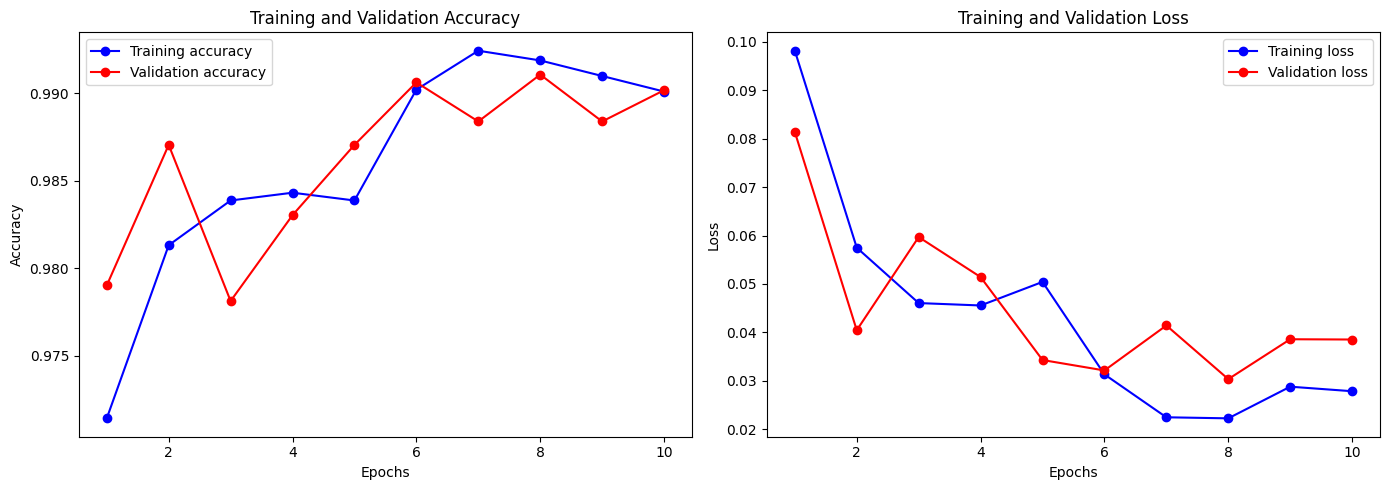

In [40]:
# TODO: Plot the training and test loss curve - for 10/20 epochs
# Extract accuracy and loss data from history

# Plot history from csv
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history from CSV
# history.history = pd.read_csv('training_log_10_epoch.csv')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Import trained model and log csv from drive
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/5_ensemble/2_output_10_epochs/ensemble_model_best_10_epoch.keras' -d '.'
!cp -r '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/5_ensemble/2_output_10_epochs/training_log_10_epoch.csv' -d '.'

In [23]:
# Define the model save path
model_save_path = 'ensemble_model_best.keras'

# Load the model
loaded_model = load_model(model_save_path)

# Verify the model structure and summary
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resizing (Resizing)         (None, 260, 260, 3)          0         ['input_3[0][0]']             
                                                                                                  
 resizing_1 (Resizing)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 efficientnetV2B2 (Function  (None, 4)                    8775010   ['resizing[0][0]']            
 al)                                                                                       

In [ ]:
# # Manual Predict label
# def load_and_preprocess_image(image_path, target_size=(224, 224)):
#     # Load the image
#     img = load_img(image_path, target_size=target_size)
#     # Convert the image to an array
#     img_array = img_to_array(img)
#     # Expand dimensions to match the expected input shape for the model
#     img_array = np.expand_dims(img_array, axis=0)
#     # Normalize the image array
#     img_array /= 255.0
#     return img_array

# # Example usage
# image_class = 'healthy'
# image_number = '10'
# image_path = f'./dataset/{image_class}/{image_class}.{image_number}.jpg'
# preprocessed_image = load_and_preprocess_image(image_path)

# # Predict

# # Make a prediction
# predictions = loaded_model.predict(preprocessed_image)
# predicted_class = np.argmax(predictions, axis=1)

# # Optionally, map the predicted class to the class label
# class_labels = list(train_generator.class_indices.keys())
# predicted_label = class_labels[predicted_class[0]]

# print(f'Predicted class: {predicted_class[0]}')
# print(f'Predicted label: {predicted_label}')

1/1 [==============================] - 0s 32ms/step
Predicted class: 1
Predicted label: healthy


In [24]:
# Evaluate the ensemble model
eval_results = loaded_model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f'Validation loss: {eval_results[0]}')
print(f'Validation accuracy: {eval_results[1]}')

70/70 [==============================] - 19s 130ms/step - loss: 0.0318 - accuracy: 0.9915
Validation loss: 0.031806349754333496
Validation accuracy: 0.9915178418159485


In [32]:
# Confusion Matrix
# Make predictions on validation data
val_generator.reset()
predictions = ensemble_model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes[:len(predicted_classes)]
class_labels = list(val_generator.class_indices.keys())

# Calculate metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

70/70 [==============================] - 9s 129ms/step
Precision: 0.9892673685619296
Recall: 0.9888392857142857
F1-score: 0.9888945199031693
Confusion Matrix:
 [[560   1   0   1]
 [  0 562   0   0]
 [  0   9 553   0]
 [  0  14   0 540]]


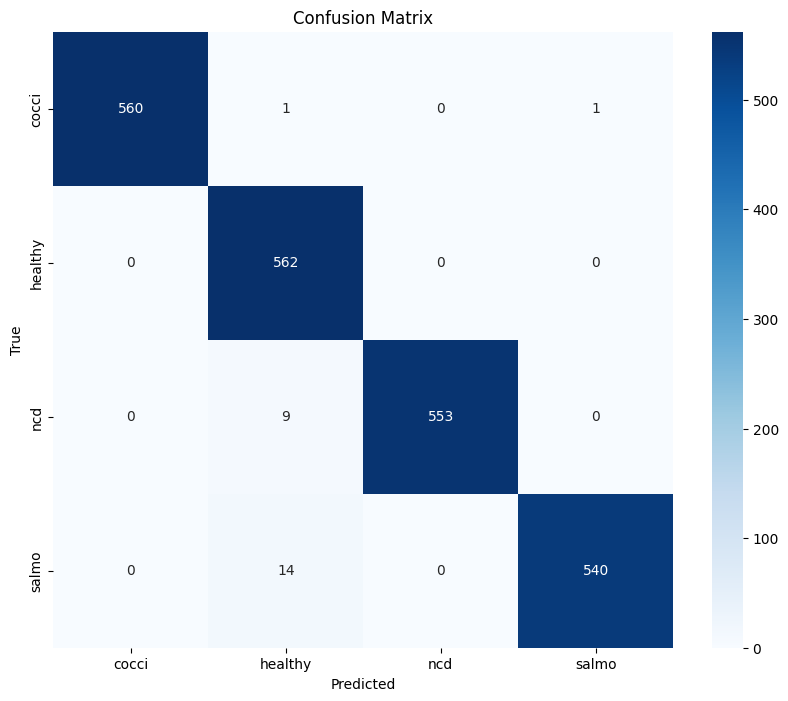

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
